In [1]:
### This notebook brings in surface reflectance and pq for a polygon area
### Then calculates NDVI, then slope of NDVI for dry months (averaged yearly)

## Load modules

In [ ]:
from scipy import stats

#----from NB1----#
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

## Function definitions : load and mask surface reflectance

In [3]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

### Bring in a shape file

In [61]:
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/mitchell_2.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#choose the index of the polygon you want within the shape file
i =0
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
print(shape_name)

mitchell_2_0


### set up datacube query

In [62]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart')

In [63]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

In [64]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [65]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### load in surface reflectance data for polygon 

In [66]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### concatenate sensor data

In [67]:
#make an array of all the clean sensor data
sensor_list = []
for sensor in [sensor1_nbart, sensor2_nbart, sensor3_nbart]:
    if sensor is not None:
        sensor_list.append(sensor)
nbart_allsensors = xr.concat(sensor_list,dim='time')

In [68]:
del sensor_list
del sensor1_nbart
del sensor2_nbart
del sensor3_nbart

### sort by time so that sensors are interleaved properly

In [69]:
#checking that we are okay in terms of time sorting
nbart_allsensors =nbart_allsensors.sortby('time')

### remove scenes with more than 80% nan values

In [70]:
#pernan is a filtration level - scenes with more nans than this per scene are removed
pernan = 0.8
nbart_allsensors = nbart_allsensors.dropna('time',  thresh = int(pernan*len(nbart_allsensors.x)*len(nbart_allsensors.y)))

### calculate ndvi

In [71]:
nbart_allsensors['NDVI'] = nbart_allsensors['nir']-nbart_allsensors['red']/nbart_allsensors['nir']-nbart_allsensors['red']

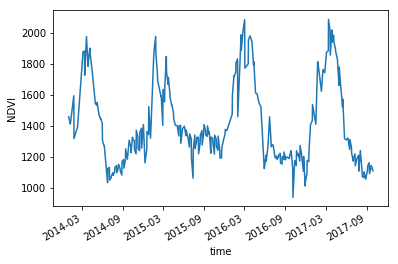

In [72]:
plt.clf()
NDVI_means = nbart_allsensors.NDVI.mean(dim =('x','y'))
NDVI_means.plot()
plt.show()

In [73]:
all_ndvi_sorted =nbart_allsensors['NDVI']
del nbart_allsensors

###
\define dry seasons

In [74]:
def dry_season(month):
    '''filters on months to return a boolean mask of a dry season between may and november
    where month could be e.g. sensor3_nbart.time.dt.month'''
    return(month>=5)&(month<=10)

def dry_vals(sensor_data):
    if sensor_data is not None:
        '''calculates dry season values'''
        dry_data = sensor_data.sel(time = dry_season(sensor_data.time.dt.month))
        return dry_data
    else:
            return None 

### Linear regression code from Symington/Krause

##### month_cut from Neil - replace?

In [75]:
# # DEfine functions
# def month_cut(data, month_1, month_2):

#     if data.dims[0] == 'time':
#         sliced_xr = list(data.groupby('time.month'))[monthDict[month_1]:monthDict[month_2] + 1]
#     elif data.dims[0] == 'month':
#         sliced_xr = list(data.groupby('month'))[monthDict[month_1]:monthDict[month_2] + 1]
    
#     #Concatenate all the arrays into one xarray
#     split_xr = sliced_xr[0][1]

    
#     for i in range(int(monthDict[month_2]) - int(monthDict[month_1])):
#         split_xr = xr.concat([split_xr, sliced_xr[i+1][1]], dim = data.dims[0])
                     
#     return split_xr

In [76]:
#Define important functions and dictionaries
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''

    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

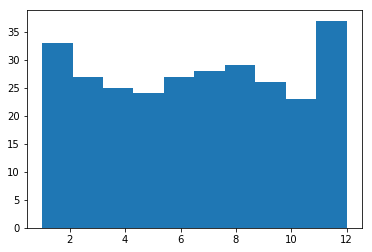

In [77]:
#plot the distribution of available surface reflectance scenes by month
plt.clf()
plt.hist(all_ndvi_sorted.time.dt.month.data)
plt.show()

In [78]:
def dry_vals(sensor_data):
    if sensor_data is not None:
        '''calculates dry season values'''
        dry_data = sensor_data.sel(time = dry_season(sensor_data.time.dt.month))
        return dry_data
    else:
            return None 

In [79]:
dry_data = all_ndvi_sorted.sel(time = dry_season(all_ndvi_sorted.time.dt.month))

In [80]:
dry_data.time.dt.month

<xarray.DataArray 'month' (time: 157)>
array([ 5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9])
Coordinates:
  * time     (time) datetime64[ns] 2014-05-01T00:25:35 ...

In [81]:
dry_ndvi = dry_vals(all_ndvi_sorted)

In [82]:
dry_ndvi

<xarray.DataArray 'NDVI' (time: 157, y: 540, x: 493)>
array([[[ 1331.60027 ,  1347.595669, ...,  1275.572968,  1288.591013],
        [ 1305.586439,  1383.607284, ...,  1344.61896 ,  1403.645814],
        ..., 
        [         nan,          nan, ...,  1428.593685,  1448.629453],
        [  761.621027,   688.581435, ...,  1511.612642,  1469.623674]],

       [[         nan,          nan, ...,  1256.547236,  1334.594126],
        [ 1354.589387,  1307.580044, ...,  1316.575612,  1394.623046],
        ..., 
        [  694.545954,   760.593604, ...,  1416.592887,  1423.61221 ],
        [  693.546027,   727.570086, ...,          nan,  1445.606289]],

       ..., 
       [[         nan,          nan, ...,  1389.436421,  1319.431373],
        [         nan,          nan, ...,  1508.492333,  1376.488471],
        ..., 
        [  843.436401,   833.432348, ...,  1443.527007,  1151.490839],
        [  707.401361,   806.42119 , ...,  1264.501785,  1179.505137]],

       [[         nan,          n

In [ ]:
plt.clf()
mean_dry_for_plots = dry_ndvi.mean(dim =('x','y'))
plt.scatter(mean_dry_for_plots)
plt.show()

In [84]:
averaged_data = dry_ndvi.groupby('time.month').mean(dim='time')

In [ ]:
averaged_data

<xarray.DataArray 'NDVI' (month: 6, y: 540, x: 493)>
array([[[ 1266.268441,  1298.36489 , ...,  1318.085685,  1334.050505],
        [ 1256.012752,  1318.845732, ...,  1415.779889,  1444.463701],
        ..., 
        [ 1152.389391,  1147.446376, ...,  1495.132063,  1499.141048],
        [ 1140.450795,  1145.768219, ...,  1505.002643,  1532.254546]],

       [[ 1091.511394,  1128.041337, ...,  1179.438347,  1176.055401],
        [ 1071.494615,  1122.641105, ...,  1290.704403,  1318.168733],
        ..., 
        [ 1114.640378,  1116.185453, ...,  1342.831542,  1320.835664],
        [ 1121.391999,  1148.193458, ...,  1324.921045,  1364.533707]],

       ..., 
       [[ 1218.303487,  1259.399556, ...,  1276.210124,  1245.812205],
        [ 1154.082257,  1242.763859, ...,  1378.86791 ,  1357.254397],
        ..., 
        [  989.245488,  1003.238931, ...,  1398.377128,  1284.918677],
        [  960.081788,  1001.835748, ...,  1342.577805,  1343.084744]],

       [[ 1221.581658,  1244.14486

In [ ]:
plt.clf()
slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = False, NDVI = True)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(slope_xr_ndvi)

plt.grid(True)
plt.colorbar()

plt.show()

Slope shape is  (540, 493)


In [ ]:
plt.clf()
slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = True, NDVI = True)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(slope_xr_ndvi)

plt.grid(True)
plt.colorbar()

plt.show()

In [ ]:
# # DEfine functions
# def month_cut(data, month_1, month_2):

#     if data.dims[0] == 'time':
#         sliced_xr = list(data.groupby('time.month'))[monthDict[month_1]:monthDict[month_2] + 1]
#     elif data.dims[0] == 'month':
#         sliced_xr = list(data.groupby('month'))[monthDict[month_1]:monthDict[month_2] + 1]
    
#     #Concatenate all the arrays into one xarray
#     split_xr = sliced_xr[0][1]

    
#     for i in range(int(monthDict[month_2]) - int(monthDict[month_1])):
#         split_xr = xr.concat([split_xr, sliced_xr[i+1][1]], dim = data.dims[0])
                     
#     return split_xr

# #Finally we plot the regression for averaged daily or monthly data with a year(s) (eg. the May to October trend)
# # If multiple years are chosen then the monthly data is averaged over multiple years (eg all October data over time period
# # is averaged)

# # #Define time interval and months range
# # time_1 = '2014-01-01'
# # time_2 = '2016-12-31'
# # month_1 = 'April'
# # #You need at least 3 months to get a meaningful lilnear regression slope
# # month_2 = 'October'





# cut_data = all_ndvi_sorted.loc[time_1:time_2]

# averaged_data = cut_data.groupby('time.month').mean(dim='time')

# #Now plot a grid for this data

# month_cut(averaged_data, 'April', 'October')

# slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = False, NDVI = True)

# fig = plt.figure(figsize =(11.69,5))
# plt.imshow(slope_xr_ndvi)

# plt.grid(True)
# plt.colorbar()

# plt.show()